# Development of N-step TD learner algorithm

In [1]:
from platform import python_version
python_version()

'3.7.3'

In [2]:
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

### Based on Chapter 7: n-step Bootstrapping from Sutton & Barto

### n-step TD

<IMG SRC="tdlambda.png">

In [3]:
from gamelearner import GameController, RandomPlayer, TDLearner
from randomwalk import RandomWalkGame

### Example 7.1 Random walk

For verification purposes, we want to replicate the results below which should match Figure 7.2 from the book which looks like this:

<IMG SRC="images/fig_7_2.png">    

### RMS Error Calculation

In [4]:
def calculate_true_values(game):
    """Returns a list of the true values of states in a
    RandomWalk game.
    """

    xp = [0, game.size+1]
    fp = [-1.0, 1.0]

    true_values = np.interp(np.arange(game.size+2), xp, fp)[1:-1]
    
    return true_values


def calculate_rms_error(values, true_values):
    """Root-mean-squared error of values compared to true values.
    """

    return np.sqrt(np.sum((np.array(values) - 
                           np.array(true_values))**2)/len(values))

size = 19
game = RandomWalkGame(size=size, 
                      terminal_rewards={'T1': -1.0, 'T2': 1.0})
true_values = calculate_true_values(game)

values = np.zeros(19)
error = calculate_rms_error(values, true_values)

assert error == 0.5477225575051662  # See benchmark code below

print(true_values)

[-0.9 -0.8 -0.7 -0.6 -0.5 -0.4 -0.3 -0.2 -0.1  0.   0.1  0.2  0.3  0.4
  0.5  0.6  0.7  0.8  0.9]


In [190]:
# Allow user to set number of repetitions (default 1)
print("Enter number of repetitions (1-100). Warning: 100 repetitions takes about 7 mins")
default_input = '1'
message = input(f"Press enter for default ({default_input}):")

try:
    repetitions = int(message or default_input)
except ValueError as err:
    print("Didn't understand that. Please try again.")
    raise err

size = 19
terminal_rewards = {'T1': -1.0, 'T2': 1.0}

game = RandomWalkGame(size=size, terminal_rewards=terminal_rewards)

# Initialization of parameters
initial_value = 0.0
gamma = 1.0

# Iterate over learning_rates and n-values
learning_rates = np.logspace(-2, 0.0, 50)
n_values = [2**i for i in range(10)]

avg_rms_error_sets = {}

t0 = time.time()
for n in n_values:

    # TEMPORARY OVERRIDE FOR TESTING
    #n = 10
    rms_error_sets = []

    rng1 = random.Random(5)

    for repetition in range(repetitions):
    
        rms_errors = []
        seed = repetition

        for learning_rate in learning_rates:

            # Initialise value function
            value_function = {
                s: 0.0 if s in game.terminal_states else initial_value
                for s in game.states
            }

            rng = random.Random(seed)

            n_iters = 10
            for iteration in range(n_iters):

                past_states = [game.state]
                past_rewards = [None]

                T = 999999
                t = 0
                while True:

                    # Behaviour policy
                    if t < T:
                        move = rng.choice(game.available_moves())
                        game.make_move([1, move])
                        past_states.append(game.state)
                        if not game.game_over:
                            reward = game.get_rewards()[1]
                        else:
                            reward = game.get_terminal_rewards()[1]
                        past_rewards.append(reward)
                        if game.game_over:
                            T = t + 1

                    # State to be updated
                    tau = t - n + 1

                    # TD(λ) update
                    if tau >= 0:

                        g = 0
                        for i in range(tau + 1, min(tau + n, T) + 1):
                            g += gamma**(i - tau - 1)*past_rewards[i]
                        if tau + n < T:
                            g += gamma**n*value_function[past_states[tau + n]]

                        value_function[past_states[tau]] += \
                                    learning_rate*(g - value_function[past_states[tau]])

                    t += 1
                    if tau == T - 1:
                        break

                game.reset()
                #break

            values = np.array(list(value_function.values())[1:size+1])
            rms_errors.append(calculate_rms_error(values, true_values))
            #break
        
        rms_error_sets.append(rms_errors)

    avg_rms_error_sets[n] = np.vstack(rms_error_sets).mean(axis=0)
    
    # OVERRIDE HERE
    #break

avg_rms_error_sets_master = avg_rms_error_sets.copy()

t1 = time.time()
total_time = t1 - t0
print(f"Execution time: {total_time:.1f}s")

print(f"Produced results for n = {list(avg_rms_error_sets.keys())}")
#print(n, rms_results[:3])

Enter number of repetitions (1-100). Warning: 100 repetitions takes about 7 mins
Press enter for default (1):
Execution time: 9.1s
Produced results for n = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512]


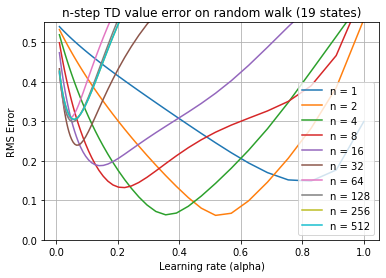

In [191]:
# Plot results

fig, ax = plt.subplots()

for n, rms_errors in avg_rms_error_sets.items():
    ax.plot(learning_rates, rms_errors, label=f'n = {n:d}')
plt.title('n-step TD value error on random walk (%d states)' % game.size)
ax.set_xlabel('Learning rate (alpha)')
ax.set_ylabel('RMS Error')
ax.set_ylim(0.0, 0.55)
plt.legend()
plt.grid()
plt.savefig("random-walk-n-step-td-{game.size}-{repetitions}.pdf")
plt.show()

In [22]:
# Use this dictionary to accumulate different results
rms_errors = {}

In [23]:
# Benchmark code

size = 19
terminal_rewards = {'T1': -1.0, 'T2': 1.0}

game = RandomWalkGame(size=size, terminal_rewards=terminal_rewards)

# Initialization of parameters
initial_value = 0.0
gamma = 1.0
n = 10

learning_rate = 0.01

# Initialise value function
value_function = {
    s: 0.0 if s in game.terminal_states else initial_value
    for s in game.states
}

rng = random.Random(5)

n_iters = 10
for iteration in range(n_iters):

    past_states = [game.state]
    past_rewards = [None]

    T = 999999
    t = 0
    while True:

        # Behaviour policy
        if t < T:
            move = rng.choice(game.available_moves())
            game.make_move([1, move])
            past_states.append(game.state)
            if not game.game_over:
                reward = game.get_rewards()[1]
            else:
                reward = game.get_terminal_rewards()[1]
            past_rewards.append(reward)
            if game.game_over:
                T = t + 1

        # State to be updated
        tau = t - n + 1

        # TD(λ) update
        if tau >= 0:

            g = 0
            for i in range(tau + 1, min(tau + n, T) + 1):
                g += gamma**(i - tau - 1)*past_rewards[i]
            if tau + n < T:
                g += gamma**n*value_function[past_states[tau + n]]

            value_function[past_states[tau]] += \
                        learning_rate*(g - value_function[past_states[tau]])

        t += 1
        if tau == T - 1:
            break

    game.reset()
    #break

values = np.array(list(value_function.values())[1:size+1])
rms_error = calculate_rms_error(values, true_values)

# Save results in this dictionary
params = {
    'n': n,
    'learning_rate': learning_rate,
    'gamma': gamma,
    'n_iters': n_iters
}
rms_errors[tuple(params.items())] = rms_error

rms_errors

{(('n', 10),
  ('learning_rate', 0.01),
  ('gamma', 1.0),
  ('n_iters', 10)): 0.49279075198489264}

In [24]:
# Check correct result produced
assert rms_errors[
    (('n', 10), 
     ('learning_rate', 0.01), 
     ('gamma', 1.0), 
     ('n_iters', 10))] == 0.49279075198489264

In [25]:
values

array([-0.06793465, -0.07726219, -0.06760227, -0.07391731, -0.07595744,
       -0.06291249, -0.02331332, -0.02287681, -0.0063066 ,  0.00689905,
        0.01194015,  0.01518813,  0.02818066,  0.05353457,  0.05502057,
        0.07147919,  0.07271629,  0.08409261,  0.06737659])

## Use this benchmark code

Source: https://github.com/ShangtongZhang/reinforcement-learning-an-introduction

In [109]:
# all states
N_STATES = 19

# all states but terminal states
STATES = np.arange(1, N_STATES + 1)

# start from the middle state
START_STATE = 10

# two terminal states
# an action leading to the left terminal state has reward -1
# an action leading to the right terminal state has reward 1
END_STATES = [0, N_STATES + 1]

# true state value from bellman equation
TRUE_VALUE = np.arange(-20, 22, 2) / 20.0
TRUE_VALUE[0] = TRUE_VALUE[-1] = 0

def temporal_difference_test(actions, value, n, alpha, gamma):
    # initial starting state
    state = START_STATE

    # arrays to store states and rewards for an episode
    # space isn't a major consideration, so I didn't use the mod trick
    states = [state]
    rewards = [0]

    # track the time
    time = 0

    # the length of this episode
    T = float('inf')
    while True:
        # go to next time step
        time += 1

        if time < T:
            # take next action from list
            action = actions[time - 1]
            assert action in [-1, 1], "Actions must be -1 or +1"
            next_state = state + action

            if next_state == 0:
                reward = -1
            elif next_state == 20:
                reward = 1
            else:
                reward = 0

            # store new state and new reward
            states.append(next_state)
            rewards.append(reward)

            if next_state in END_STATES:
                T = time

        # get the time of the state to update
        update_time = time - n
        if update_time >= 0:
            returns = 0.0
            # calculate corresponding rewards
            for t in range(update_time + 1, min(T, update_time + n) + 1):
                returns += pow(gamma, t - update_time - 1) * rewards[t]
            # add state value to the return
            if update_time + n <= T:
                returns += pow(gamma, n) * value[states[(update_time + n)]]
            state_to_update = states[update_time]
            # update the state value
            if not state_to_update in END_STATES:
                value[state_to_update] += alpha * (returns - value[state_to_update])
        if update_time == T - 1:
            break
        state = next_state

In [110]:
TRUE_VALUE

array([ 0. , -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1,  0. ,
        0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  0. ])

In [111]:
value = np.zeros(21)

np.sqrt(np.sum(np.power(value - TRUE_VALUE, 2)) / N_STATES)

0.5477225575051662

### N-step TD - Classes for adding to game-learner

In [187]:
from abc import ABC, abstractmethod

def discounted_sequence_generator(sequence, gamma):
    """Returns a generator that yields each item of sequence
    discounted by gamma at each time-step.
    
    Example:
    >>> list(discounted_sequence_generator([10.0]*5, 0.75))
    [10.0, 7.5, 5.625, 4.21875, 3.1640625]
    """
    
    x = 1.0
    for item in sequence:
        yield x*item
        x = x*gamma


# Initialization of agent
class Agent:
    
    def __init__(self, policy, name=None, initial_value=0.0, n=1,
                 gamma=1.0, learning_rate=0.1):

        self.name = name
        self.policy = policy
        self.initial_value = initial_value
        self.n = n
        self.gamma = gamma
        self.learning_rate = learning_rate
        self.saved_game_states = None
        self.past_rewards = None
        self.value_function = None
        self.update_count = None
        self.updates_on = True

    def initialize(self, game, role):
        
        # Initialise value function
        self.value_function = {}
        self.update_count = 0
        
        self.saved_game_states = {}
        self.saved_rewards = {}  # TODO: Need to replace past_rewards
        
        # This must be called before starting the first game
        self.reset_game_information(game, role)
        
        # Some behaviour policies need reseting (e.g. random seed)
        self.policy.reset()

    def get_value(self, state_key):
        """Returns a value from TDLearner's value_function for the
        game state represented by state_key. If there is no item for
        that state, returns the initial_value instead.
        """

        return self.value_function.get(state_key, self.initial_value)

    def save_state(self, game, state_key):
        """Adds state_key to a list of keys stored in dictionary
        self.saved_game_states for each game being played.
        """

        self.saved_game_states.get(game, []).append(state_key)

    def decide_next_move(self, game, role, show=False):
        """Returns the agent's next move in game (using its policy)
        and assuming they are playing this role.

        Args:
            game (Game): Game being played.
            role (object): Role that the player is playing.
            show (bool): Print messages if True.

        Returns:
            move (tuple): Tuple containing (role, action).
        """

        action = self.policy.choose_action(game, role)
        move = (role, action)

        # Save chosen after-state for learning updates later
        # TODO: Should save timestep with it
        next_state = game.next_state(game.state, move)
        next_state_key = game.generate_state_key(next_state, role)
        self.save_state(game, next_state_key)

        if show:
            move_format = game.help_text['Move format']
            print("%s's turn (%s): %s" % (self.name, move_format,
                                          str(position)))

        return move

    def make_move(self, game, role, show=False):
        """Ask player to make a move.  This method will call
        the player's decide_next_move method and will then
        execute the resulting move in the game.

        Args:
            game (Game): Game that player is playing.
            role (int): Role that the player is playing.
            show (bool): Print messages if True.
        """

        assert not game.game_over, "Can't make move. Game is over."

        # Player needs to trigger game start if method exists
        if len(game.moves) == 0:
            try:
                game.start()
            except AttributeError:
                pass

        move = self.decide_next_move(game, role, show)
        game.make_move(move)
        
        #self.t += 1  # TODO: Need to figure out when to do this

    def update(self, game, reward, show=False, debug=False):
        """Update TDLearner's value function based on current reward 
        from game.  This gets called by GameController during a game
        whenever rewards are distributed and the player has received
        one.

        Args:
            game (Game): Game that player is playing.
            role (int): Player role.
            reward (float): Reward value.
            show (bool): Print a message if True.
        
        TODO: Should add a 'terminal' or 'done' argument to signal
        the terminal state reached (gameover).
        """

        # Save the current state and reward for future value
        # updates.  TODO: Needs to be generalized to multiple games
        self.past_rewards.append(reward)

        if self.updates_on:
            prev_states = self.saved_game_states[game]
            prev_rewards = self.past_rewards
            
            # TODO: Do we need to track and update self.t?
            # Or can we just use prev_states
            #t = len(prev_states) - 1

            if not game.game_over:
                
                tau = self.t - self.n + 1
                self.td_lambda_update(prev_states, prev_rewards, tau,
                                      debug=debug)

            else:
                # Complete final state-value updates for timesteps tau
                # to current (terminal) timestep
                T = self.t + 1
                for tau in range(self.t - self.n + 1, T):
                    self.td_lambda_update(prev_states, prev_rewards, tau=tau, 
                                          t_max=T, debug=debug)

        self.t += 1   # TODO: Need to figure out when to do this
                      # on 2-player games (works here)
                      # It's connected to the question of when
                      # to add the state and reward to saved_states
                      # Better idea is to base it on len(prev_states)
                      # maybe

        if show:
            print("%s got %s reward." % (self.name, reward))

    def td_lambda_update(self, prev_states, prev_rewards, tau, 
                         t_max=np.inf, debug=False):
        """Updates the value for the past state that occurred
        in timestep tau using the Bellman equation.  If tau is 
        not provided, then it is calculated as follows:
        
        tau = t - n + 1
        
        Where:
            t is the current timestep (self.t)
            n is the lambda value (self.n)  
        
        If tau < 0 no update is possible so none is made.
        
        Args:
            tau (int): Previous time-step to be updated.
            t_max (int or np.inf): The maximum timestep to include.  
                Set to infinity or a high number if you want to
                include all timesteps from tau to tau + n.  Set
                to t if the game has eneded.
        """

        # Set tau, the timestep of the state that will have its
        # value updated
        
        assert len(prev_states) == len(prev_rewards)
        
        #if debug and self.t == 177:
        #    breakpoint()
        #    show = True
        #else:
        show = False

        if tau >= 0:

            assert tau < len(prev_states), "Not enough past states."

            n = self.n
            #g = 0
            #for i in range(tau + 1, min(tau + n, t_max) + 1):
            #    # TODO: Can this be vectorized?
            #    g += self.gamma**(i - tau - 1)*prev_rewards[i]
            
            discounted_rewards = discounted_sequence_generator(
                prev_rewards[tau+1:min(tau + n, t_max) + 1], 
                self.gamma
            )
            g = sum(list(discounted_rewards))
            
            if tau + n < t_max:
                g += self.gamma**n*self.get_value(prev_states[tau + n])

            # Update value of state at timestep tau
            state_key = prev_states[tau]
            state_value = self.get_value(state_key)
            
            if show:
                print(f"prev_states[{tau}]: {state_value}")
    
            agent.value_function[state_key] = state_value + \
                self.learning_rate*(g - state_value)
        
            if show:
                print(f"value_function[{state_key.__repr__()}]: {self.get_value(state_key)}")

    def reset_game_information(self, game, role):
        """Delete state and reward history for specified game
        and set timestep (t) to zero.
        """

        state_key = game.generate_state_key(game.state, role)
        self.saved_game_states[game] = [state_key]
        self.past_rewards = [None]
        self.t = 0

    def gameover(self, game):

        pass

class Policy(ABC):
    
    def __init__(self, name):
        
        self.name = name
    
    @abstractmethod
    def choose_action(self, game, role):
        
        pass


class RandomPolicy(Policy):
    
    def __init__(self, name="RANDOM", seed=None):
        
        super().__init__(name)
        
        # Independent random number generator for sole use
        # by this instance
        self.seed = seed
        self.reset()

    def choose_action(self, game, role):
        
        available_moves = game.available_moves()
        
        action = self.rng.choice(available_moves)
        
        return action
    
    def reset(self):
        
        self.rng = random.Random(self.seed)

        
class PredefinedActions(Policy):
    
    def __init__(self, actions, name="PREDEFINED"):
        
        super().__init__(name)
        
        self.actions = actions
        self.t = 0

    def choose_action(self, game, role):
        
        available_moves = game.available_moves()
        
        action = self.actions[self.t]
        
        assert action in game.available_moves()

        self.t += 1

        return action

    def reset(self):
        
        self.t = 0

In [194]:
# Allow user to set number of repetitions (default 1)
print("Enter number of repetitions (1-100). Warning: 100 repetitions takes about 7 mins")
default_input = '1'
message = input(f"Press enter for default ({default_input}):")

try:
    repetitions = int(message or default_input)
except ValueError as err:
    print("Didn't understand that. Please try again.")
    raise err

# Environment parameters
size = 19
terminal_rewards = {'T1': -1.0, 'T2': 1.0}
game = RandomWalkGame(size=size, terminal_rewards=terminal_rewards)

# Agent parameters
initial_value = 0.0
gamma = 1.0
seed = 5
agent = Agent(RandomPolicy(seed=seed), name="Random", 
              initial_value=initial_value, 
              gamma=gamma)

# Iterate over learning_rates and n-values
learning_rates = np.logspace(-2, 0.0, 50)
n_values = [2**i for i in range(8)]

rms_error_sets = {}

t0 = time.time()

# TODO: Should be repeating the test 100 times for each
# pair of n, alpha values and averaging the results.

for n in n_values:

    # TODO: Should be repeating the test 100 times for each
    # pair of n, alpha values and averaging the results.
    
    # OVERRIDE
    #n = 10
    agent.n = n

    rms_results = []

    for learning_rate in learning_rates:

        agent.learning_rate = learning_rate

        # Initialize agent with empty value function
        agent.initialize(game, role=1)

        # Testing policy rng was reset
        some_moves = [agent.decide_next_move(game, 1) for _ in range(5)]
        agent.initialize(game, role=1)
        some_moves2 = [agent.decide_next_move(game, 1) for _ in range(5)]
        assert some_moves == some_moves2
        
        agent.initialize(game, role=1)
        # Testing value function is zero
        value_function = {
            s: 0.0 if s in game.terminal_states else agent.initial_value
            for s in game.states
        }
        agents_v = {s: agent.get_value(s) for s in game.states}
        assert agents_v == value_function

        n_iters = 10
        for iteration in range(n_iters):

            # Reset agent's game information
            agent.reset_game_information(game, role=1)

            # Testing
            #assert agent.t == 0
            #assert agent.saved_game_states[game] == [game.state]
            #assert agent.past_rewards == [None]

            while not game.game_over:

                # Behaviour policy
                move = agent.decide_next_move(game, 1)
                game.make_move(move)

                # Get rewards
                #reward = game.get_rewards()[1]
                if not game.game_over:
                    reward = game.get_rewards()[1]
                else:
                    reward = game.get_terminal_rewards()[1]

                debug = True if iteration == n_iters - 1 else False

                # Update the value for state in timestep tau,
                # where tau = t - n + 1
                agent.update(game, reward, debug=debug)

            # TODO: Should this be where final final TD(λ) updates happen?
            agent.gameover(game)  # Currently redundant
            game.reset()

            # OVERRIDE
            #break

        values = pd.Series(agent.value_function, index=game.states).fillna(agent.initial_value)
        rms_results.append(calculate_rms_error(values[1:game.size+1], true_values))
        #break

    rms_error_sets[n] = rms_results
    #break

t1 = time.time()
total_time = t1 - t0
print(f"Execution time: {total_time:.1f}s")

print(n, rms_results[0])
# For n=1
# 1 [0.5392683523771096, 0.5311550178396927, 0.5233241063497756]

# For n=10, t = 11
# 10 [0.49279075198489264, 0.4444604816372286, 0.4014578835834512]
# assert rms_results[0] == 0.49279075198489264
# prev_states[2]: 0.009388775398326584
# value_function['J']: 0.009081736826626132

# For n=128
# 128 [0.5067675989278085, 0.5346220655366686, 0.5882351606556061]

Enter number of repetitions (1-100). Warning: 100 repetitions takes about 7 mins
Press enter for default (1):
Execution time: 4.7s
128 0.5067675989278084


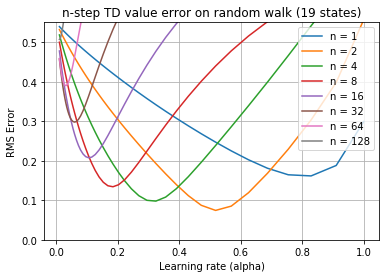

In [193]:
# Plot results

fig, ax = plt.subplots()

for n, rms_errors in rms_error_sets.items():
    ax.plot(learning_rates, rms_errors, label='n = %d' % n)
plt.title('n-step TD value error on random walk (%d states)' % game.size)
ax.set_xlabel('Learning rate (alpha)')
ax.set_ylabel('RMS Error')
ax.set_ylim(0.0, 0.55)
plt.legend()
plt.grid()
#plt.savefig("random_walk_tdl_%d.pdf" % game.size)
plt.show()

In [78]:
#assert rms_error_sets == rms_error_sets_master

## Simple One-Episode Tests of Value Function Updates

### Test 1

In [167]:
gamma = 1.0
n = 10
learning_rate = 0.1
actions = ['r']*10

game = RandomWalkGame(size=19, terminal_rewards={'T1': -1.0, 'T2': 1.0})

agent = Agent(PredefinedActions(actions), name="Test 1", initial_value=0.0, 
              gamma=gamma)
agent.n = n
agent.learning_rate = learning_rate
agent.initialize(game, role=1)

while not game.game_over:

    # Behaviour policy
    move = agent.decide_next_move(game, 1)
    game.make_move(move)

    # Get rewards
    #reward = game.get_rewards()[1]
    if not game.game_over:
        reward = game.get_rewards()[1]
    else:
        reward = game.get_terminal_rewards()[1]

    debug = True if iteration == n_iters - 1 else False

    # Update the value for state in timestep tau,
    # where tau = t - n + 1
    agent.update(game, reward, debug=debug)

agent.gameover(game)

# Convert actions to (1, -1)
action_map = {'l': -1, 'r': 1}
actions = [action_map[a] for role, a in game.moves]

# Reference values from benchmark codetest_values = np.zeros(N_STATES + 2)
test_values = np.zeros(N_STATES + 2) 
temporal_difference_test(actions, test_values, n, learning_rate, gamma=gamma)

comparison = pd.DataFrame({'Reference Values': test_values, 
                           'Test Values': agent.value_function}, 
                          index=game.states)
comparison

,Reference Values,Test Values
T1,0.0,NaN
A,0.0,NaN
B,0.0,NaN
C,0.0,NaN
D,0.0,NaN
E,0.0,NaN
F,0.0,NaN
G,0.0,NaN
H,0.0,NaN
I,0.0,NaN


In [168]:
assert np.all(comparison.dropna()['Reference Values'] == comparison.dropna()['Test Values'])

### Test 2

In [169]:
gamma = 0.9
n = 10
learning_rate = 1.0
actions = ['r']*11

game = RandomWalkGame(size=19, terminal_rewards={'T1': -1.0, 'T2': 1.0})

agent = Agent(PredefinedActions(actions), name="Test 2", initial_value=0.0, 
              gamma=gamma)
agent.n = n
agent.learning_rate = learning_rate
agent.initialize(game, role=1)

while not game.game_over:

    # Behaviour policy
    move = agent.decide_next_move(game, 1)
    game.make_move(move)

    # Get rewards
    #reward = game.get_rewards()[1]
    if not game.game_over:
        reward = game.get_rewards()[1]
    else:
        reward = game.get_terminal_rewards()[1]

    debug = True if iteration == n_iters - 1 else False

    # Update the value for state in timestep tau,
    # where tau = t - n + 1
    agent.update(game, reward, debug=debug)

agent.gameover(game)

# Convert actions to (1, -1)
action_map = {'l': -1, 'r': 1}
actions = [action_map[a] for role, a in game.moves]

# Reference values from benchmark codetest_values = np.zeros(N_STATES + 2)
test_values = np.zeros(N_STATES + 2) 

temporal_difference_test(actions, test_values, n, learning_rate, gamma=gamma)

comparison = pd.DataFrame({'Reference Values': test_values, 
                           'Test Values': agent.value_function}, 
                          index=game.states)
comparison

,Reference Values,Test Values
T1,0.000000,NaN
A,0.000000,NaN
B,0.000000,NaN
C,0.000000,NaN
D,0.000000,NaN
E,0.000000,NaN
F,0.000000,NaN
G,0.000000,NaN
H,0.000000,NaN
I,0.000000,NaN


In [170]:
assert np.isclose(comparison.dropna()['Reference Values'], comparison.dropna()['Test Values']).all()

### Test 3

In [175]:
gamma = 0.9
n = 3
learning_rate = 0.9
actions = ['l']*11

game = RandomWalkGame(size=19, terminal_rewards={'T1': -1.0, 'T2': 1.0})

agent = Agent(PredefinedActions(actions), name="Test 3", initial_value=0.0, 
              gamma=gamma)
agent.n = n
agent.learning_rate = learning_rate
agent.initialize(game, role=1)

while not game.game_over:

    # Behaviour policy
    move = agent.decide_next_move(game, 1)
    game.make_move(move)

    # Get rewards
    #reward = game.get_rewards()[1]
    if not game.game_over:
        reward = game.get_rewards()[1]
    else:
        reward = game.get_terminal_rewards()[1]

    debug = True if iteration == n_iters - 1 else False

    # Update the value for state in timestep tau,
    # where tau = t - n + 1
    agent.update(game, reward, debug=debug)

agent.gameover(game)

# Convert actions to (1, -1)
action_map = {'l': -1, 'r': 1}
actions = [action_map[a] for role, a in game.moves]

# Reference values from benchmark codetest_values = np.zeros(N_STATES + 2)
test_values = np.zeros(N_STATES + 2) 
temporal_difference_test(actions, test_values, n, learning_rate, gamma=gamma)

comparison = pd.DataFrame({'Reference Values': test_values, 
                           'Test Values': agent.value_function}, 
                          index=game.states)
comparison

,Reference Values,Test Values
T1,0.000,NaN
A,-0.900,-0.900
B,-0.810,-0.810
C,-0.729,-0.729
D,0.000,0.000
E,0.000,0.000
F,0.000,0.000
G,0.000,0.000
H,0.000,0.000
I,0.000,0.000


In [176]:
assert np.isclose(comparison.dropna()['Reference Values'], comparison.dropna()['Test Values']).all()

### Test 4

In [177]:
gamma = 0.9
n = 10
learning_rate = 0.9
actions = ['l', 'l', 'l', 'l', 'l', 'l', 'r', 'l', 'l', 'l', 'r', 'l', 'l', 'l']

game = RandomWalkGame(size=19, terminal_rewards={'T1': -1.0, 'T2': 1.0})

agent = Agent(PredefinedActions(actions), name="Test 4", initial_value=0.0, 
              gamma=gamma)
agent.n = n
agent.learning_rate = learning_rate
agent.initialize(game, role=1)

while not game.game_over:

    # Behaviour policy
    move = agent.decide_next_move(game, 1)
    game.make_move(move, show=True)

    # Get rewards
    #reward = game.get_rewards()[1]
    if not game.game_over:
        reward = game.get_rewards()[1]
    else:
        reward = game.get_terminal_rewards()[1]

    debug = True if iteration == n_iters - 1 else False

    # Update the value for state in timestep tau,
    # where tau = t - n + 1
    agent.update(game, reward, debug=debug)

agent.gameover(game)

# Convert actions to (1, -1)
action_map = {'l': -1, 'r': 1}
actions = [action_map[a] for role, a in game.moves]

# Reference values from benchmark codetest_values = np.zeros(N_STATES + 2)
test_values = np.zeros(N_STATES + 2)
temporal_difference_test(actions, test_values, n, learning_rate, gamma=gamma)

comparison = pd.DataFrame({'Reference Values': test_values, 
                           'Test Values': agent.value_function}, 
                          index=game.states)
comparison

Player 1 made move 'l'
Player 1 made move 'l'
Player 1 made move 'l'
Player 1 made move 'l'
Player 1 made move 'l'
Player 1 made move 'l'
Player 1 made move 'r'
Player 1 made move 'l'
Player 1 made move 'l'
Player 1 made move 'l'
Player 1 made move 'r'
Player 1 made move 'l'
Player 1 made move 'l'
Player 1 made move 'l'


,Reference Values,Test Values
T1,0.000000,NaN
A,-0.900000,-0.900000
B,-0.875610,-0.875610
C,-0.788049,-0.788049
D,-0.574488,-0.574488
E,-0.517039,-0.517039
F,-0.348678,-0.348678
G,0.000000,0.000000
H,0.000000,0.000000
I,0.000000,0.000000


In [178]:
assert np.isclose(comparison.dropna()['Reference Values'], comparison.dropna()['Test Values']).all()

### Test 5

In [179]:
gamma = 0.9
n = 10
learning_rate = 0.9
seed = 2

game = RandomWalkGame(size=19, terminal_rewards={'T1': -1.0, 'T2': 1.0})

agent = Agent(RandomPolicy(seed=seed), name="Test 5", initial_value=0.0, 
              gamma=gamma)
agent.n = n
agent.learning_rate = learning_rate
agent.initialize(game, role=1)

while not game.game_over:

    # Behaviour policy
    move = agent.decide_next_move(game, 1)
    game.make_move(move)

    # Get rewards
    #reward = game.get_rewards()[1]
    if not game.game_over:
        reward = game.get_rewards()[1]
    else:
        reward = game.get_terminal_rewards()[1]

    debug = True if iteration == n_iters - 1 else False

    # Update the value for state in timestep tau,
    # where tau = t - n + 1
    agent.update(game, reward, debug=debug)

agent.gameover(game)

# Convert actions to (1, -1)
action_map = {'l': -1, 'r': 1}
actions = [action_map[a] for role, a in game.moves]

# Reference values from benchmark codetest_values = np.zeros(N_STATES + 2)
test_values = np.zeros(N_STATES + 2) 
temporal_difference_test(actions, test_values, n, learning_rate, gamma=gamma)

comparison = pd.DataFrame({'Reference Values': test_values, 
                           'Test Values': agent.value_function}, 
                          index=game.states)
comparison

,Reference Values,Test Values
T1,0.000000,NaN
A,0.000000,NaN
B,0.000000,NaN
C,0.000000,NaN
D,0.000000,NaN
E,0.000000,NaN
F,0.000000,0.000000
G,0.000000,0.000000
H,0.000000,0.000000
I,0.000000,0.000000


In [180]:
assert np.isclose(comparison.dropna()['Reference Values'], comparison.dropna()['Test Values']).all()

In [ ]:
prev_states = ['J', 'K', 'J', 'K', 'J', 'K', 'L', 'K', 'J', 'K', 'J', 'I', 'H']
              
prev_rewards = [None, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

n = 10
gamma = 1.0
initial_value = 0.0
value_function = {
    'J': 0.009388775398326584, 'K': 0.012724472068223015, 'L': 0.015790004710492304, 
    'I': -0.00403859530840691, 'H': -0.021315081771718508, 'G': -0.021496015967472096, 
    'F': -0.054275718752572394, 'E': -0.06948717697342521, 'D': -0.06598448738239086, 
    'C': -0.04893934900883692, 'B': -0.04901704716984233, 'A': -0.0490099501, 
    'M': 0.029488099958858597, 'N': 0.05430058175403064, 'O': 0.05502056748246712, 
    'P': 0.07147918642363447, 'Q': 0.07271629098862856, 'R': 0.0840926138566933, 
    'S': 0.06737658637280254
}


t_max = np.inf

t = 11

def n_step_td_update(prev_states, prev_rewards, t, n, gamma,
                     value_function, t_max=np.inf):
    """Carries out an n-step TD update to the previous state-value
    at timestep (t - n + 1) using the values from steps (t - n + 2)
    to (t + 1) or t_max, whichever comes first.
    
    If (t - n + 1) < 0, no update is carried out.
    
    Note: Usually, when you call this function in timestep t, you
    set tau to t - n + 1.
    
    If the episode is over (i.e. state t is a terminal state), then
    set t_max to t and it will not look for a value in timestep 
    (t + 1).
    """

    # Value for state in timestep tau will be updated
    tau = t - n + 1

    if tau >= 0 and len(prev_states) > 1:

        # Original version
        #g = sum([gamma**(i - tau - 1)*prev_rewards[i] 
        #         for i in range(tau + 1, min(tau + n, t_max) + 1)])

        # This is the fastest
        discounted_rewards = discounted_sequence_generator(
            prev_rewards[tau+1:min(tau + n, t_max) + 1], 
            gamma
        )
        g = sum(list(discounted_rewards))
        
        print(g)
        
        # Vectorized version
        # Note: This is only faster for n>25
        #g = np.power(np.full((n), gamma), np.arange(min(n, t_max - tau)))*prev_rewards[tau+1:min(tau + n, t_max) + 1]

        if tau + n < t_max:
            g += gamma**n*value_function.get(prev_states[tau + n], initial_value)

        state_key = prev_states[tau]
        state_value = value_function.get(state_key, initial_value)

        print(f"prev_states[{tau}]: {state_value}")

        value_function[state_key] = state_value + learning_rate*(g - state_value)

        print(f"value_function[{state_key.__repr__()}]: {value_function[state_key]}")

#t += 1  # TODO: Need to figure out when to do this

In [ ]:
n_step_td_update(prev_states, prev_rewards, t, n, gamma,
                 value_function, t_max=np.inf)

# t = 9:
#prev_states[1]: 0.012893795981118266
#value_function['K']: 0.012724472068223015
#10 0.49279075198489264


# Test cases
#prev_states = ['J', 'K', 'J', 'K', 'J', 'K', 'L', 'K', 'J', 'K', 'J', 'I', 'H']
#prev_rewards = [None, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
#
#n = 10
#gamma = 1.0
#initial_value = 0.0
#value_function = {
#    'J': 0.009388775398326584, 'K': 0.012724472068223015, 'L': 0.015790004710492304, 
#    'I': -0.00403859530840691, 'H': -0.021315081771718508, 'G': -0.021496015967472096, 
#    'F': -0.054275718752572394, 'E': -0.06948717697342521, 'D': -0.06598448738239086, 
#    'C': -0.04893934900883692, 'B': -0.04901704716984233, 'A': -0.0490099501, 
#    'M': 0.029488099958858597, 'N': 0.05430058175403064, 'O': 0.05502056748246712, 
#    'P': 0.07147918642363447, 'Q': 0.07271629098862856, 'R': 0.0840926138566933, 
#    'S': 0.06737658637280254
#}
# t = 11:
#prev_states[2]: 0.009388775398326584
#value_function['J']: 0.009081736826626132
#10 0.49279075198489264


### Speed tests on discounting calculation

In [ ]:
random.seed(1)
prev_rewards = [None] + [random.random() for _ in range(t + 1)]

n = 10
gamma = 0.9
t_max = np.inf
t = 11

tau = t - n + 1

In [ ]:
# Pure Python version 1

g = sum([gamma**(i - tau - 1)*prev_rewards[i] 
                 for i in range(tau + 1, min(tau + n, t_max) + 1)])

assert g == 3.206433194301773

In [ ]:
# Numpy version 1

g = np.sum(np.power(np.full((n), gamma), np.arange(min(n, t_max - tau)))*prev_rewards[tau+1:min(tau + n, t_max) + 1])

assert np.isclose(g, 3.206433194301773) 

In [ ]:
# Pure Python version 2

g = sum([gamma**(i)*prev_rewards[i + tau + 1] 
                 for i in range(0, min(n, t_max - tau))])

assert g == 3.206433194301773

In [ ]:
# Pure Python version 3

def discounted_sequence_generator(sequence, gamma):
    """Returns a generator that yields each item of sequence
    discounted by gamma at each time-step.
    
    Example:
    >>> list(discounted_sequence_generator([10.0]*5, 0.75))
    [10.0, 7.5, 5.625, 4.21875, 3.1640625]
    """
    
    x = 1.0
    for item in sequence:
        yield x*item
        x = x*gamma

g = sum(list(discounted_sequence_generator(prev_rewards[tau+1:min(tau + n, t_max) + 1], gamma)))

assert g == 3.206433194301773

In [ ]:
# Numpy version 2

def sum_discounted_rewards(prev_rewards, tau, n, t_max, gamma):
    
    gamma_values = np.full(10, gamma)
    gamma_values[0] = 1.0
    rewards = prev_rewards[tau+1:min(tau + n, t_max) + 1]
    
    return sum(np.cumprod(gamma_values)*rewards)

g = sum_discounted_rewards(prev_rewards, tau, n, t_max, gamma)

assert np.isclose(g, 3.206433194301773) 

In [ ]:
%timeit g = sum([gamma**(i - tau - 1)*prev_rewards[i] for i in range(tau + 1, min(tau + n, t_max) + 1)])

In [ ]:
%timeit g = sum([gamma**(i)*prev_rewards[i + tau + 1] for i in range(0, min(n, t_max - tau))])

In [ ]:
%timeit g = sum_discounted_rewards(prev_rewards, tau, n, t_max, gamma)

In [ ]:
%timeit g = sum(list(discounted_sequence_generator(prev_rewards[tau+1:min(tau + n, t_max) + 1], gamma)))

In [ ]:
%timeit g = np.sum(np.power(np.full((n), gamma), np.arange(min(n, t_max - tau)))*prev_rewards[tau+1:min(tau + n, t_max) + 1])

In [ ]:
def discounted_sum_generator(sequence, gamma):
    
    x = 1.0
    
    for item in sequence:
        
        yield x*item
        x = x*gamma

list(discounted_sum_generator([1.0]*5, 0.9))

In [ ]:
# Outputs should look like this before summing
[gamma**(i - tau - 1)*prev_rewards[i] 
                 for i in range(tau + 1, min(tau + n, t_max) + 1)]